In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [11]:
load = pd.read_csv('2032 ADS PCM V2.4.1 Public Data/Processed Data/Load.csv').iloc[0:25,1:].values
df2 = pd.read_csv('output/EDprice.csv',header=None)*12

In [3]:
solarmap = pd.read_csv('2032 ADS PCM V2.4.1 Public Data/Processed Data/SolarMap.csv').iloc[:,1:].values
solarprofile = pd.read_csv('2032 ADS PCM V2.4.1 Public Data/Processed Data/SolarProfile.csv').iloc[0:25,1:].values
windmap = pd.read_csv('2032 ADS PCM V2.4.1 Public Data/Processed Data/WindMap.csv').iloc[:,1:].values
windprofile = pd.read_csv('2032 ADS PCM V2.4.1 Public Data/Processed Data/WindProfile.csv').iloc[0:25,1:].values
hydromap = pd.read_csv('2032 ADS PCM V2.4.1 Public Data/Processed Data/HydroMap.csv').iloc[:,1:].values
hydroprofile = pd.read_csv('2032 ADS PCM V2.4.1 Public Data/Processed Data/HydroProfile.csv').iloc[0:25,1:].values

In [4]:
hydroprofile.shape

(25, 1218)

In [5]:
np.max(solarprofile)

1105.58108

In [6]:
solargen = np.matmul(solarprofile,solarmap)
windgen = np.matmul(windprofile,windmap)
hydrogen = np.matmul(hydroprofile,hydromap)

In [7]:
df1 = pd.DataFrame(load - solargen - windgen - hydrogen)

In [8]:
new_index = np.linspace(0, df1.index.max(), 289)
df1 = df1.set_index([np.repeat(np.arange(len(df1) // 25), 25), df1.index])
df1 = df1.reindex([np.repeat(np.arange(len(df1) // 25), 289), new_index])
df1 = df1.interpolate()
df1 = df1.reset_index(level=0, drop=True)

In [9]:
df1 = df1.reset_index(drop=True)[0:288]

In [253]:
df2.max()

0    7949.061057
1    3536.067398
2    3536.067398
3    7949.061057
4    9000.000000
5    3536.067398
6    3536.067398
dtype: float64

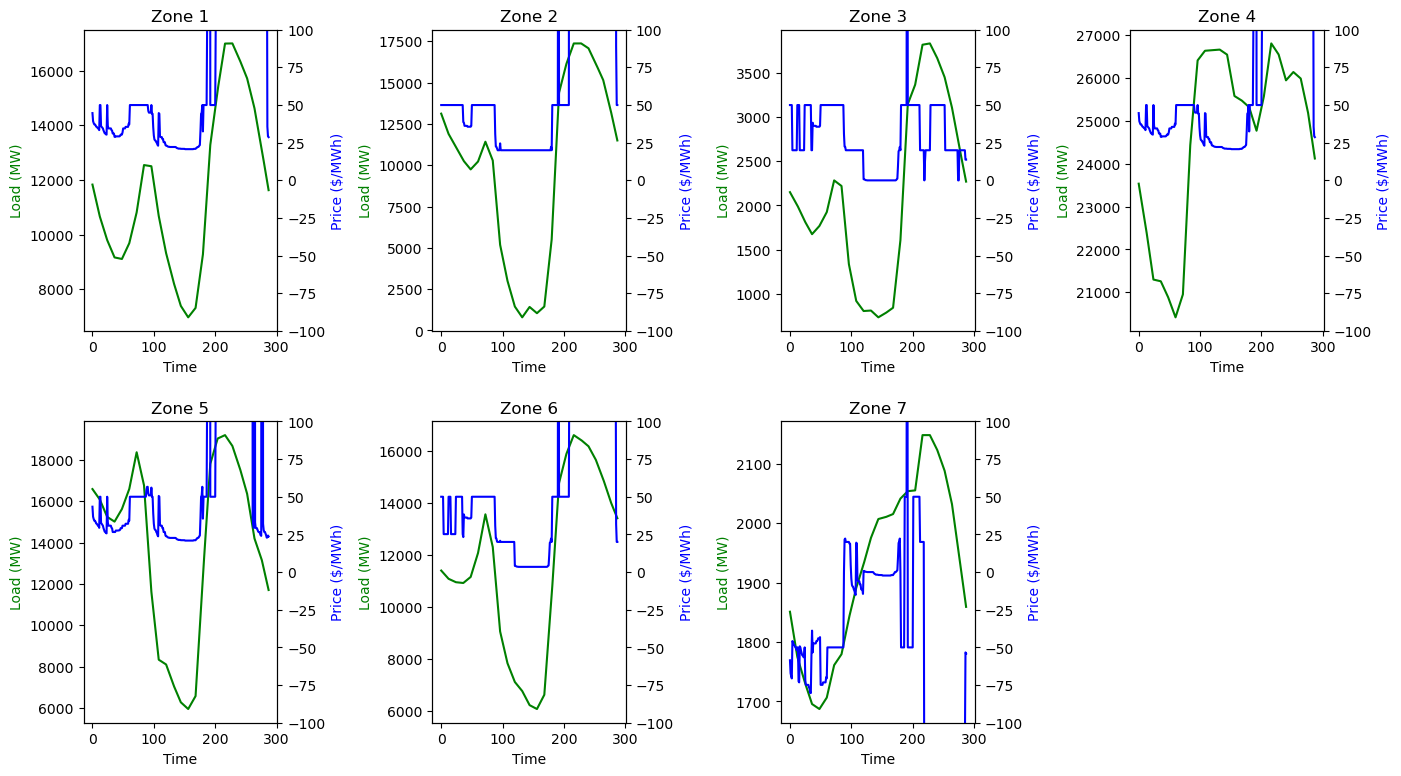

In [12]:
# Define the time range
time = range(288)

# Create the figure and subplots, adjusting for a 16:9 ratio
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 9))

# Remove the extra, unused subplot (axes[1, 3])
fig.delaxes(axes[1][3])

# Flatten the axes array to make it easier to iterate over
axes = axes.flatten()

# Loop through each zone
for i in range(7):
    # Plot load and price for each zone
    ax1 = axes[i]
    ax2 = ax1.twinx()

    ax1.plot(time, df1.iloc[:, i], 'g-')
    ax2.plot(time, df2.iloc[:, i], 'b-')

    # Set y-axis limits
    ax2.set_ylim(-100, 100)

    # Set labels
    ax1.set_ylabel('Load (MW)', color='g')
    ax2.set_ylabel('Price ($/MWh)', color='b')
    ax1.set_xlabel('Time')

    # Set title for each subplot
    ax1.set_title(f'Zone {i+1}')

# Adjust the space between plots
plt.subplots_adjust(wspace=0.8, hspace=0.3)

# Show the plot
plt.show()